# Rating Prediction

Through this notebook, several models are trained and tested in order to find the most accurate (produces less errors) when predicting movie ratings. As stated on the readme file, we developed 6 different models:

          - Linear Regression model;
          - Ridge model (alpha = 0.5);
          - Lasso Model (alpha = 0.5);
          - Bayesian Ridge;
          - Neural Network;
          - Keras model.
 
<b><i>Disclaimer : </i></b>  Due to the big volume of data and big number of regressors, we focused our attention on movies produced in 2020 and 2021, on this stage of the project. So first, there is some data filtering.

  For further research on the models' properties, all documentation is available at: 
  
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html <i>(Linear Regression models)</i>
      
- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential <i>(Keras model)</i>

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras import metrics
from keras.layers import Dense
from keras.models import Sequential

from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error , r2_score ,mean_squared_error

from IPython.display import display_html

In [2]:
movies_info = pd.read_csv('data/movies_info.csv', index_col = 'tconst')
movie_actors = pd.read_csv('data/movies_actors.csv')

In [3]:
movies_info.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,Action,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
tconst,,,,,,,,,,,,,,,,,,,,,
tt1465519,movie,Caged Animal,The Wrath of Cain,0,2010,\N,84,4.6,1534,1,...,0,0,0,0,0,0,0,0,0,0
tt1629424,movie,Trump Card,Trump Card,0,2010,\N,\N,3.0,20,1,...,0,0,0,0,0,0,0,0,0,0
tt1629391,movie,Tere Bin Laden,Tere Bin Laden,0,2010,\N,95,7.2,10175,0,...,0,0,0,0,0,0,0,0,0,0
tt1629377,movie,Kidnapped,Secuestrados,0,2010,\N,85,6.4,7309,1,...,0,0,0,0,0,0,0,0,0,0
tt1629372,movie,Rewind,Rewind,0,2010,\N,80,4.9,155,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
movie_actors.head()

,tconst,ordering,nconst,category,job,characters,startYear,averageRating
0,tt0011216,1,nm0290157,actress,\N,"[""Soledad""]",2019,6.3
1,tt0011216,2,nm0300388,actor,\N,\N,2019,6.3
2,tt0011216,3,nm0869559,actor,\N,"[""Miguélan""]",2019,6.3
3,tt0011216,4,nm0595321,actor,\N,"[""Réal""]",2019,6.3
4,tt0016906,10,nm0530110,actress,\N,\N,2014,5.6


In [5]:
movies_info = movies_info[movies_info['startYear'] >= 2020]
movies_info = movies_info[movies_info['runtimeMinutes'] != r'\N']

In [6]:
movie_actors = movie_actors.loc[movie_actors['tconst'].isin(movies_info.index)]
actors = pd.DataFrame(0, index = movies_info.index, columns = movie_actors['nconst'].unique())
movies_info = pd.merge(movies_info,actors, on = 'tconst')

In [7]:
movie_actors.head()

,tconst,ordering,nconst,category,job,characters,startYear,averageRating
9,tt0062336,1,nm0815612,actor,\N,"[""Viudo""]",2020,6.3
10,tt0062336,2,nm1860495,actress,\N,"[""Fantasma""]",2020,6.3
11,tt0062336,3,nm0016013,actor,\N,"[""Silva""]",2020,6.3
12,tt0062336,4,nm0739834,actress,\N,"[""Lola""]",2020,6.3
17,tt0093119,1,nm0409481,actor,\N,"[""Nick Hollister""]",2020,3.6


In [8]:
movies_info.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,Action,...,nm2778042,nm11685100,nm3226390,nm0302466,nm6153878,nm0144812,nm3080119,nm9428255,nm3766704,nm10678594
tconst,,,,,,,,,,,,,,,,,,,,,
tt10252330,movie,Granny Nanny,Enkel für Anfänger,0,2020,\N,104,6.6,488,0,...,0,0,0,0,0,0,0,0,0,0
tt12869176,movie,Banksters,Banksterzy,0,2020,\N,106,5.4,125,0,...,0,0,0,0,0,0,0,0,0,0
tt12868184,movie,Benyamin the Troublemaker 2,Benyamin Biang Kerok 2,0,2020,\N,97,6.5,28,0,...,0,0,0,0,0,0,0,0,0,0
tt12868336,movie,Life with Music,Life with Music,0,2020,\N,97,6.3,6,0,...,0,0,0,0,0,0,0,0,0,0
tt13062088,movie,Ride Scare,Ride Scare,0,2020,\N,72,4.1,18,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
for movie, info in movies_info.iterrows():
    for actor in movie_actors[movie_actors['tconst'] == movie]['nconst']:
        movies_info[actor][movie] = 1

<ipython-input-9-4010260654c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_info[actor][movie] = 1


In [10]:
movies_info.head()

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes,Action,...,nm2778042,nm11685100,nm3226390,nm0302466,nm6153878,nm0144812,nm3080119,nm9428255,nm3766704,nm10678594
tconst,,,,,,,,,,,,,,,,,,,,,
tt10252330,movie,Granny Nanny,Enkel für Anfänger,0,2020,\N,104,6.6,488,0,...,0,0,0,0,0,0,0,0,0,0
tt12869176,movie,Banksters,Banksterzy,0,2020,\N,106,5.4,125,0,...,0,0,0,0,0,0,0,0,0,0
tt12868184,movie,Benyamin the Troublemaker 2,Benyamin Biang Kerok 2,0,2020,\N,97,6.5,28,0,...,0,0,0,0,0,0,0,0,0,0
tt12868336,movie,Life with Music,Life with Music,0,2020,\N,97,6.3,6,0,...,0,0,0,0,0,0,0,0,0,0
tt13062088,movie,Ride Scare,Ride Scare,0,2020,\N,72,4.1,18,0,...,0,0,0,0,0,0,0,0,0,0


To train and test any model, you must split the data into train and test sets. Before splitting, we standardized our regressors.

In [11]:
y = movies_info['averageRating']
x = movies_info.drop(['titleType','primaryTitle','originalTitle','endYear'], axis = 1)

In [12]:
scaler = StandardScaler()
x[['startYear','runtimeMinutes','numVotes']] = scaler.fit_transform(x[['startYear','runtimeMinutes','numVotes']])

In [13]:
#Split Train and Test
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.80, random_state = 50)

### Model results function

After preparing the data, it is time to train our models. In order to do so, we created a function that receives as arguments:

    - model: model to be trained and tested;
    - x_train: training set (regressors);
    - y_train: training set (dependent variable);
    - x_test: test set (regressors);
    - y_test: test set (dependent variable).

The function will then return a data frame displaying the R2, MAE, MSE for both the train and test data.

For further information on the evaluation metrics used: https://scikit-learn.org/stable/modules/model_evaluation.html

In [14]:
#Function to get models results
def results(model,x_train,y_train,x_test,y_test):

    model.fit(x_train,y_train.values.ravel())
        
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
        
    r2 = r2_score(y_train,y_pred_train),r2_score(y_test,y_pred_test)
    mae = mean_absolute_error(y_train,y_pred_train), mean_absolute_error(y_test,y_pred_test)
    mse = mean_squared_error(y_train,y_pred_train), mean_squared_error(y_test,y_pred_test)
    result = pd.DataFrame([[r2[0],r2[1]],
                           [mae[0],mae[1]],
                           [mse[0],mse[1]]],index = ['R2','MAE','MSE'],columns = ['Train Data','Test Data'])
    return result

### OLS Model

In [15]:
# object creation and model fit OLS
ols_model = linear_model.LinearRegression()
ols_results = results(ols_model,x_train,y_train,x_test,y_test)
ols_results

,Train Data,Test Data
R2,1.000000e+00,0.999997
MAE,4.145025e-15,0.000614
MSE,1.282927e-28,0.000009


### Ridge Model

<b><i>alpha = 0.5 </i></b>

In [16]:
# object creation and model fit Ridge with parameter alpha=0.5
rdg_model = linear_model.Ridge(alpha = 0.5)
rdg_results = results(rdg_model,x_train,y_train,x_test,y_test)
rdg_results

,Train Data,Test Data
R2,1.000000e+00,1.000000e+00
MAE,5.758596e-05,2.181443e-04
MSE,1.227519e-08,7.849414e-08


### Lasso Model

<b><i>alpha = 0.5 </i></b>

In [17]:
# object creation and model fit Lasso with parameter alpha=0.5
lss_model = linear_model.Lasso(alpha = 0.5)
lss_results = results(lss_model,x_train,y_train,x_test,y_test)
lss_results

,Train Data,Test Data
R2,0.967598,0.967568
MAE,0.239817,0.237683
MSE,0.090002,0.087596


### BayesianRidge Model


In [18]:
# object creation and model fit BayesianRidge with parameter compute_score=True
brdg_model = linear_model.BayesianRidge(compute_score=True)
brdg_results = results(brdg_model,x_train,y_train,x_test,y_test)
brdg_results

,Train Data,Test Data
R2,1.000000e+00,1.000000e+00
MAE,1.136793e-09,8.498236e-09
MSE,1.178904e-17,1.178610e-16


### Neural Network

In [19]:
# Object creation Neural Network
nn_model = MLPRegressor(random_state=1, activation='relu', max_iter=300, solver='adam')
nn_results = results(nn_model,x_train,y_train,x_test,y_test)
nn_results

,Train Data,Test Data
R2,0.999180,0.994833
MAE,0.022509,0.092314
MSE,0.002277,0.013957


### Keras model

In [20]:
Y_train,Y_test = y_train.values, y_test.values

In [21]:
k_model = Sequential([
    Dense(10, input_dim=x_train.shape[1], activation='relu'),
    Dense(30, activation='relu'),
    Dense(40, activation='relu'),
    Dense(1)
])
k_model.compile(optimizer ='adam', loss = 'mean_squared_error', 
            metrics =[metrics.mae])

In [22]:
k_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                189870    
_________________________________________________________________
dense_1 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 191,481
Trainable params: 191,481
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = k_model.fit(x_train, Y_train, validation_data=(x_test,Y_test), epochs = 40, batch_size=32)

Epoch 1/40
157/157 [==============================] - 5s 22ms/step - loss: 26.3370 - mean_absolute_error: 4.4720 - val_loss: 0.3458 - val_mean_absolute_error: 0.4669
Epoch 2/40
157/157 [==============================] - 1s 7ms/step - loss: 0.2294 - mean_absolute_error: 0.3670 - val_loss: 0.0767 - val_mean_absolute_error: 0.2167
Epoch 3/40
157/157 [==============================] - 1s 7ms/step - loss: 0.0396 - mean_absolute_error: 0.1536 - val_loss: 0.0672 - val_mean_absolute_error: 0.2017
Epoch 4/40
157/157 [==============================] - 1s 7ms/step - loss: 0.0203 - mean_absolute_error: 0.1019 - val_loss: 0.0490 - val_mean_absolute_error: 0.1715
Epoch 5/40
157/157 [==============================] - 1s 7ms/step - loss: 0.0192 - mean_absolute_error: 0.0958 - val_loss: 0.0453 - val_mean_absolute_error: 0.1651
Epoch 6/40
157/157 [==============================] - 1s 6ms/step - loss: 0.0185 - mean_absolute_error: 0.0926 - val_loss: 0.0390 - val_mean_absolute_error: 0.1526
Epoch 7/40
157

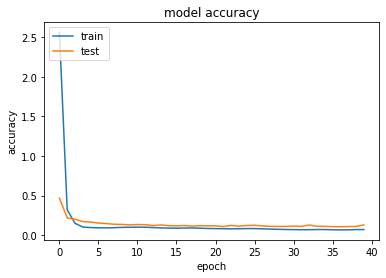

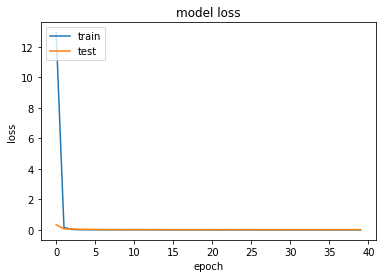

In [24]:
# summarize history for accuracy
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
y_pred_train = k_model.predict(x_train)
y_pred_test = k_model.predict(x_test)
k_r2 = r2_score(y_train,y_pred_train),r2_score(y_test,y_pred_test)
k_mae = mean_absolute_error(y_train,y_pred_train), mean_absolute_error(y_test,y_pred_test)
k_mse = mean_squared_error(y_train,y_pred_train), mean_squared_error(y_test,y_pred_test)
k_results = pd.DataFrame([[k_r2[0],k_r2[1]],
                          [k_mae[0],k_mae[1]],
                          [k_mse[0],k_mse[1]]],index = ['R2','MAE','MSE'],columns = ['Train Data','Test Data'])
k_results

,Train Data,Test Data
R2,0.995986,0.989168
MAE,0.086492,0.129366
MSE,0.011150,0.029256


## Model Comparison

In [26]:
modelos = (ols_results,rdg_results,lss_results,brdg_results,nn_results,k_results)
train = np.zeros((len(modelos), 3))
test = np.zeros((len(modelos), 3))

for i in range(len(modelos)):
    train[i][0] = modelos[i]['Train Data']['R2']
    test[i][0] = modelos[i]['Test Data']['R2']     
    train[i][1] = modelos[i]['Train Data']['MAE']
    test[i][1] = modelos[i]['Test Data']['MAE']
    train[i][2] = modelos[i]['Train Data']['MSE']
    test[i][2] = modelos[i]['Test Data']['MSE']

models_names = ['OLS','Ridge','Lasso','BayesianRidge','Neural Network', 'Keras Model']
train_resume = pd.DataFrame(data = train, columns = ['R2','MAE','MSE'], index= models_names)
test_resume = pd.DataFrame(data = test, columns = ['R2','MAE','MSE'], index= models_names)


train_styler = train_resume.style.set_table_attributes("style='display:inline'").set_caption('Train Data')
test_styler = test_resume.style.set_table_attributes("style='display:inline'").set_caption('Test Data')
space = "\xa0" * 15
display_html(train_styler._repr_html_()+ space  + test_styler._repr_html_(), raw=True)

,R2,MAE,MSE
OLS,1.000000,0.000000,0.000000
Ridge,1.000000,0.000058,0.000000
Lasso,0.967598,0.239817,0.090002
BayesianRidge,1.000000,0.000000,0.000000
Neural Network,0.999180,0.022509,0.002277
Keras Model,0.995986,0.086492,0.011150
,R2,MAE,MSE
OLS,0.999997,0.000614,0.000009
Ridge,1.000000,0.000218,0.000000
Lasso,0.967568,0.237683,0.087596


All models used produce extremely good results for the evaluation measures used.
Note that we want a model with:

- R2 as close to 1 as possible;
- MAE and MSE as close to 0 as possible.

To decide which model to use, we first focus our attention on Test data (Train data was used to train the model).

The model that produces the best results is the <b>BayesianRidge Model</b>.